In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.error import URLError

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

import time


In [6]:


def plot_roc_curves(results, X_test, y_test, title="ROC Curves"):
    plt.figure(figsize=(7,5))
    for name, clf in results.items():
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X_test)[:,1]
        else:
            try:
                probs = clf.decision_function(X_test)
            except Exception:
                continue
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def evaluate_and_report(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    if hasattr(model, "predict_proba"):
        try:
            auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        except Exception:
            auc = np.nan
    else:
        try:
            auc = roc_auc_score(y_test, model.decision_function(X_test))
        except Exception:
            auc = np.nan

    print(f"Model: {name}")
    print("Accuracy:", round(acc,4), "| AUC:", (round(auc,4) if not np.isnan(auc) else "N/A"))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    return {"model": name, "accuracy": acc, "auc": auc}


In [8]:


def load_heart_cleveland():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    colnames = [
        "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
    ]
    df = pd.read_csv(url, header=None, names=colnames)
    df = df.replace("?", np.nan).dropna().astype(float)
    df['target'] = (df['target'] > 0).astype(int)
    return df

def load_pima_diabetes():
    url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
    return pd.read_csv(url)

def load_breast_cancer_dataset():
    ds = load_breast_cancer(as_frame=True)
    return ds.frame.copy()


In [9]:


def get_models_and_spaces(random_state=42):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=200, solver="liblinear"),
        "SVM": SVC(probability=True),
        "RandomForest": RandomForestClassifier(random_state=random_state),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state),
    }

    param_spaces = {
        "LogisticRegression": {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"]
        },
        "SVM": {
            "C": [0.1, 1, 10, 50],
            "kernel": ["rbf", "linear"],
            "gamma": ["scale", "auto"]
        },
        "RandomForest": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10, 20]
        },
        "XGBoost": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 8],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    }

    return models, param_spaces


In [10]:


def run_experiment(df, features, target_col, dataset_name,
                   test_size=0.2, random_state=42, n_iter_search=15):

    print("\n" + "="*70)
    print(f"Dataset: {dataset_name} | Samples: {df.shape[0]} | Features: {len(features)}")
    print("="*70)

    X = df[features].values
    y = df[target_col].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models, spaces = get_models_and_spaces(random_state=random_state)

    fitted_models = {}
    results_summary = []

    for name, model in models.items():
        print("\n--- Training:", name, "---")
        param_dist = spaces.get(name, {})

        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=min(n_iter_search, len(param_dist)*3) if param_dist else 1,
            scoring="roc_auc",
            n_jobs=-1,
            cv=3,
            random_state=random_state,
            verbose=0
        )

        t0 = time.time()
        search.fit(X_train, y_train)
        t1 = time.time()

        best = search.best_estimator_
        print("Best params:", search.best_params_)
        print("Train time: {:.1f}s".format(t1 - t0))

        rec = evaluate_and_report(name, best, X_test, y_test)
        rec["fit_time_sec"] = t1 - t0
        results_summary.append(rec)
        fitted_models[name] = best

    plot_roc_curves(fitted_models, X_test, y_test, title=f"{dataset_name} - ROC Curves")

    return pd.DataFrame(results_summary).sort_values(by="accuracy", ascending=False).reset_index(drop=True)



Dataset: Heart Disease | Samples: 297 | Features: 13

--- Training: LogisticRegression ---
Best params: {'penalty': 'l2', 'C': 0.01}
Train time: 0.1s
Model: LogisticRegression
Accuracy: 0.8667 | AUC: 0.9509
Classification Report:
              precision    recall  f1-score   support

           0     0.8529    0.9062    0.8788        32
           1     0.8846    0.8214    0.8519        28

    accuracy                         0.8667        60
   macro avg     0.8688    0.8638    0.8653        60
weighted avg     0.8677    0.8667    0.8662        60


--- Training: SVM ---
Best params: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}
Train time: 1.6s
Model: SVM
Accuracy: 0.85 | AUC: 0.9531
Classification Report:
              precision    recall  f1-score   support

           0     0.8286    0.9062    0.8657        32
           1     0.8800    0.7857    0.8302        28

    accuracy                         0.8500        60
   macro avg     0.8543    0.8460    0.8479        60
weighte

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:09:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2}
Train time: 0.8s
Model: XGBoost
Accuracy: 0.8333 | AUC: 0.9018
Classification Report:
              precision    recall  f1-score   support

           0     0.8235    0.8750    0.8485        32
           1     0.8462    0.7857    0.8148        28

    accuracy                         0.8333        60
   macro avg     0.8348    0.8304    0.8316        60
weighted avg     0.8341    0.8333    0.8328        60



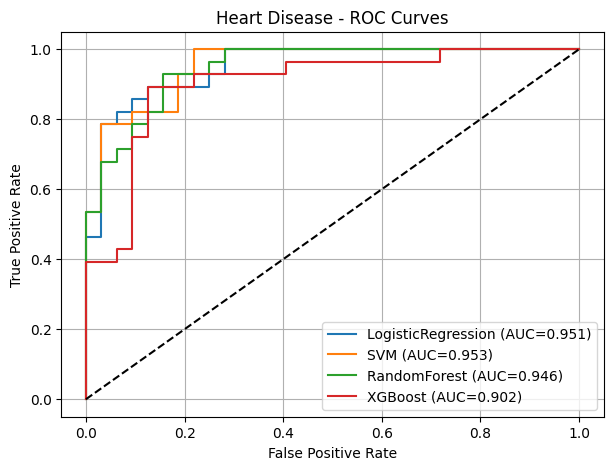

In [12]:

# Run Heart Disease Experiment

all_summaries = {}

try:
    heart = load_heart_cleveland()
    s_heart = run_experiment(
        heart,
        [c for c in heart.columns if c!="target"],
        "target",
        "Heart Disease"
    )
    all_summaries["Heart"] = s_heart
except Exception as e:
    print("Heart dataset error:", e)



Dataset: Pima Diabetes | Samples: 768 | Features: 8

--- Training: LogisticRegression ---
Best params: {'penalty': 'l2', 'C': 0.01}
Train time: 0.1s
Model: LogisticRegression
Accuracy: 0.7143 | AUC: 0.8083
Classification Report:
              precision    recall  f1-score   support

           0     0.7745    0.7900    0.7822       100
           1     0.5962    0.5741    0.5849        54

    accuracy                         0.7143       154
   macro avg     0.6853    0.6820    0.6835       154
weighted avg     0.7120    0.7143    0.7130       154


--- Training: SVM ---
Best params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.1}
Train time: 2.4s
Model: SVM
Accuracy: 0.7143 | AUC: 0.7698
Classification Report:
              precision    recall  f1-score   support

           0     0.7333    0.8800    0.8000       100
           1     0.6471    0.4074    0.5000        54

    accuracy                         0.7143       154
   macro avg     0.6902    0.6437    0.6500       154
weighted

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:09:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Train time: 2.5s
Model: XGBoost
Accuracy: 0.7338 | AUC: 0.8252
Classification Report:
              precision    recall  f1-score   support

           0     0.7810    0.8200    0.8000       100
           1     0.6327    0.5741    0.6019        54

    accuracy                         0.7338       154
   macro avg     0.7068    0.6970    0.7010       154
weighted avg     0.7290    0.7338    0.7306       154



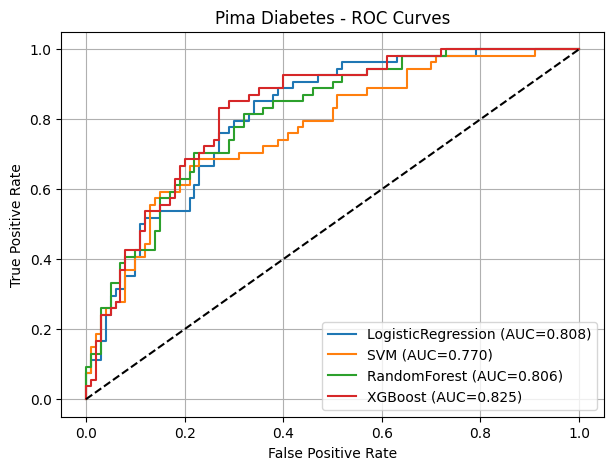

In [13]:
# Run Pima Diabetes Experiment

try:
    pima = load_pima_diabetes()
    s_pima = run_experiment(
        pima,
        [c for c in pima.columns if c!="Outcome"],
        "Outcome",
        "Pima Diabetes"
    )
    all_summaries["Pima"] = s_pima
except Exception as e:
    print("Pima dataset error:", e)



Dataset: Breast Cancer | Samples: 569 | Features: 30

--- Training: LogisticRegression ---
Best params: {'penalty': 'l2', 'C': 1}
Train time: 0.1s
Model: LogisticRegression
Accuracy: 0.9825 | AUC: 0.9957
Classification Report:
              precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114


--- Training: SVM ---
Best params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Train time: 0.4s
Model: SVM
Accuracy: 0.9737 | AUC: 0.9957
Classification Report:
              precision    recall  f1-score   support

           0     0.9535    0.9762    0.9647        42
           1     0.9859    0.9722    0.9790        72

    accuracy                         0.9737       114
   macro avg     0.9697    0.9742    0.9719       114
weighted a

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:09:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2}
Train time: 2.9s
Model: XGBoost
Accuracy: 0.9474 | AUC: 0.9934
Classification Report:
              precision    recall  f1-score   support

           0     0.9500    0.9048    0.9268        42
           1     0.9459    0.9722    0.9589        72

    accuracy                         0.9474       114
   macro avg     0.9480    0.9385    0.9429       114
weighted avg     0.9474    0.9474    0.9471       114



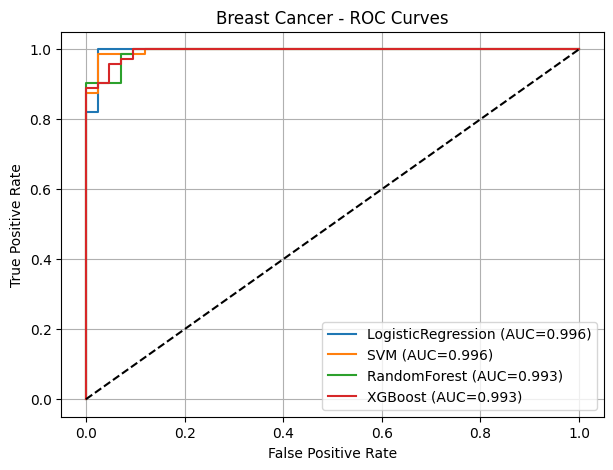

In [14]:
# Run Breast Cancer Experiment

try:
    bc = load_breast_cancer_dataset()
    s_bc = run_experiment(
        bc,
        [c for c in bc.columns if c!="target"],
        "target",
        "Breast Cancer"
    )
    all_summaries["BreastCancer"] = s_bc
except Exception as e:
    print("Breast cancer dataset error:", e)


In [15]:
# Comparison


print("\n" + "="*70)
print("Best Models per Dataset")
print("="*70)

comparison = []
for ds, summary_df in all_summaries.items():
    best = summary_df.iloc[0]
    comparison.append({
        "Dataset": ds,
        "Best Model": best["model"],
        "Accuracy": round(best["accuracy"],4),
        "AUC": (round(best["auc"],4) if not np.isnan(best["auc"]) else "N/A")
    })

comp_df = pd.DataFrame(comparison)
display(comp_df)



Best Models per Dataset


,Dataset,Best Model,Accuracy,AUC
0,Heart,LogisticRegression,0.8667,0.9509
1,Pima,XGBoost,0.7338,0.8252
2,BreastCancer,LogisticRegression,0.9825,0.9957
